# Homework 2: Two-layer neural network
### Due Tuesday, January 29, 2019, 5pm
#### Jesse Zhu
#### ML-W2019

Using the MNIST hand-written digits dataset, we aim to categorize the digits 0-9 with a two-layer neural network,
composed of one hidden layer and one output layer. Both layers will use the sigmoid activation function, and the
network is fully connected.

Sigmoid function: 1/ (1+ e^-z)

In [1]:
#import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#IMPORT DATA#################
testfile = "mnist_test.csv"
trainfile = "mnist_train.csv"

#Data is 785 columns by N rows. First column = Label (0-9), others = 0:255
test_data = np.genfromtxt(testfile, skip_header=True, delimiter=',')
train_data = np.genfromtxt(trainfile, skip_header=True, delimiter=',')

#PREPROCESSING###############

#SCALE to 0:1
test_data[:,1:] /= 255
train_data[:,1:] /= 255

In [79]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

#Accuraccy function
def acc(w1, w2, data, debug = 0):
    """
    input: 
        w1: input to hidden weights [785 by hu]
        w2: hidden to output weights [(hu+1) by 10]
        data: matrix of N data points by 785 values, where the first value is the target (0-9), and the rest are
            scaled gray-scale values between 0 and 1
    output: Percentage of correct classifications, where a classification is taken using the highest perceptron
        output value
    """
    length = len(data[:,0])
    xi = np.append(np.ones([length,1]), data[:, 1:],1) #Append 1s for bias & strip label from data[]
    h_act = np.array(list(map(sigmoid, xi @ w1[:, :]))) #N by (hidden_units)
    hi = np.append(np.ones([length,1]), h_act[:,:],1) #N by (hidden_units+1)

    o_act = np.array(list(map(sigmoid, hi @ w2[:, :]))) #N by 10

    amax = o_act.argmax(axis=1) #Predicted value
    if debug:
        print(o_act.shape)
        print(amax[0:25])
    ret = np.sum(amax == data[:,0])
    return ret/length

#Confusion matrix
def cm(w1,w2, data):
    """
    input: 
        w1: input to hidden weights [785 by hu]
        w2: hidden to output weights [(hu+1) by 10]
        data: matrix of N data points by 785 values, where the first value is the target (0-9), and the rest are
            scaled gray-scale values between 0 and 1
    output: confusion matrix 11x11 including labels (actual vs predicted)
    """
    length = len(data[:,0])
    xi = np.append(np.ones([length,1]), data[:, 1:],1) #Append 1s for bias & strip label from data[]
    h_act = np.array(list(map(sigmoid, xi @ w1[:, :]))) #N by (hidden_units)
    hi = np.append(np.ones([length,1]), h_act[:,:],1) #N by (hidden_units+1)
#sigmoid
    o_act = np.array(list(map(sigmoid, hi @ w2[:, :]))) #N by 10
    #o_act= hi @ w2[:, :]
    #print(o_act[0:3,:])
    
    m = np.zeros([11,11])
    m[0,1:] = np.arange(10)
    m[1:,0] = np.arange(10)
    
    for i in range(0, length):
        actual = int(data[i, 0])
        predic = int((o_act[i,:]).argmax(axis=0))
        m[actual+1, predic+1] += 1
        
    return m.astype(int)

#Training through back-propagation
def train(w1, w2, data, lr, m, debug = 0):
    """
    input: 
        w1: input to hidden weights [785 by hu]
        w2: hidden to output weights [(hu+1) by 10]
        data: matrix of N data points by 785 values, where the first value is the target (0-9), and the rest are
            scaled gray-scale values between 0 and 1
        lr: learning rate, (0:1)
        m: momentum, (0:1)
    output: Altered input weight matricies
    """
    length = len(data[:,0])
    oh_deltas_prev = np.zeros(w2.shape) #initialize previous weights to 0 (momentum calculations)
    hi_deltas_prev = np.zeros(w1.shape)

    for i in range(0,length):
        #Forward Prop
        xi = np.append([1], data[i, 1:]) #add "1" to input beginning for offset -> 1x785
        hidden = np.array(list(map(sigmoid, xi @ w1[:, :]))) #1 by (hidden_units)
        hi = np.append([1], hidden) #1 by (hidden_units+1)
        #out = np.array(list(map(sigmoid, hi @ w2[:, :]))) #1 by 10
        out = np.array(list(map(sigmoid, np.dot(hi,w2[:, :])))) #1 by 10
        
        target = np.full((10),0.1)
        tindex = int(data[i,0])
        target[tindex] = 0.9 #1x10 of 0s, with target = 0.9, else 0.1
        #Error
        err_o = out * (1-out) *(target-out) #1 by 10 array, output error
        #err_h = hidden * (1-hidden) * (w2[1:,:]@err_o) #hu by 1 array, hidden error
        err_h = hidden * (1-hidden) * np.dot(w2[1:,:],err_o) #hu by 1 array, hidden error
        
        #Backpropagation Deltas
        oh_deltas = lr * np.outer(hi, err_o) +m*oh_deltas_prev #(hu+1) by 10
        hi_deltas = lr * np.outer(xi, err_h) +m*hi_deltas_prev #785 by hu
        oh_deltas_prev = oh_deltas
        hi_deltas_prev = hi_deltas
        #Update weights
        w2 += oh_deltas
        w1 += hi_deltas
    return

***# Hidden =  10 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  932    0    4    2    6    1   11    9   15    0]
 [   1    0 1102    2    5    0    2    3    3   18    0]
 [   2   11    1  919   12    9    1    9   18   48    4]
 [   3    8    0   19  905    0   23    2   14   32    7]
 [   4    0    1    2    0  913    0   12    2   11   41]
 [   5   13    1    9   38   12  690   26    6   82   15]
 [   6   11    3   13    0    9    0  891    2   29    0]
 [   7    1    4   12    6    8    1    1  918   30   46]
 [   8    8    4    8   12    3    7   12    6  904   10]
 [   9    4    1    0   14   27    5    2   12   21  923]]
final test acc =  0.9097909790979097
final train acc =  0.9185486424773747


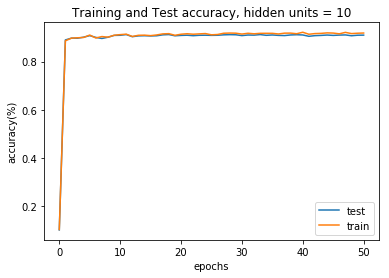

***# Hidden =  20 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  960    0    1    1    0    5    5    4    4    0]
 [   1    0 1113    4    3    0    1    2    0   11    1]
 [   2    6    3  955    3   10    0    9   11   31    4]
 [   3    5    1   12  929    0   26    1    5   25    6]
 [   4    1    1    5    1  888    0   17    2   10   57]
 [   5    7    2    6   23    1  806   12    7   24    4]
 [   6   16    3   14    1    8   14  890    1    9    2]
 [   7    0    9   19    7    0    1    0  956   10   25]
 [   8    8    7    2    8    3   10    8    2  917    9]
 [   9    6    5    1   10   14    7    0    6   18  942]]
final test acc =  0.9356935693569357
final train acc =  0.9551492524875415


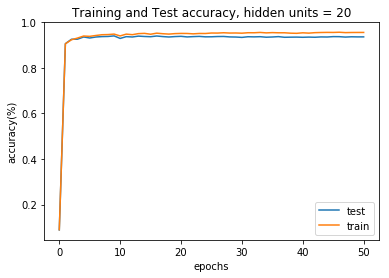

***# Hidden =  100 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  970    0    4    0    0    0    1    1    3    1]
 [   1    1 1120    1    4    1    1    2    0    5    0]
 [   2    5    2  986    8    1    1    6    5   15    3]
 [   3    0    1    7  969    0   13    0    5   10    5]
 [   4    2    0    2    0  943    0    6    1    2   26]
 [   5    4    1    1    7    0  855    6    4    7    7]
 [   6    8    3    1    1    2   13  925    0    5    0]
 [   7    0    3   13    2    4    0    0  977   12   16]
 [   8    7    3    2    1    4    6    5    3  940    3]
 [   9    5    3    0   10   11    2    1    5    6  966]]
final test acc =  0.9651965196519652
final train acc =  0.9938332305538425


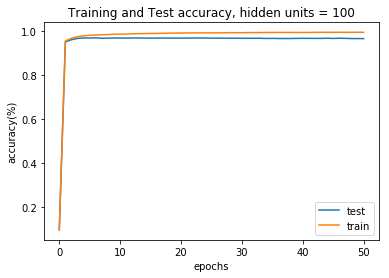

In [88]:
################# EXPERIMENT 1 ####################

epochs = 50
learning_rate = 0.1
momentum = 0.9
hidden_units = [10, 20, 100]


for hu in hidden_units:
    print("***# Hidden = ",hu,"***************")
    w_hi = (np.random.rand(785,hu) * 0.10) - 0.05 #weights, input to hidden
    w_oh = (np.random.rand(hu+1,10) * 0.10) - 0.05 #weights, hidden to output
    acc_test = []
    acc_train = []

    acc_test.append(acc(w_hi, w_oh,test_data)) #initial accuracy values
    acc_train.append(acc(w_hi, w_oh,train_data))
    
    for i in range(0,epochs):
        train(w_hi, w_oh, train_data, learning_rate, momentum)
        acc_test.append(acc(w_hi, w_oh,test_data))
        acc_train.append(acc(w_hi, w_oh,train_data))
        print(i, end='', flush=True)
    print(" ") #newline
    
    print(cm(w_hi, w_oh, test_data))
    print("final test acc = ", acc_test[len(acc_test)-1])
    print("final train acc = ", acc_train[len(acc_train)-1])

    plt.plot(acc_test)
    plt.plot(acc_train)
    plt.xlabel("epochs")
    plt.ylabel("accuracy(%)")
    title = "Training and Test accuracy, hidden units = " + str(hu)
    plt.title(title)
    plt.legend(("test", "train"),loc='lower right')
    plt.show()

# Hidden Unit Number Discussion

The number of hidden units has a large effect on accuracy, going from 91 to 93.5 to 96.5% on the test data when using 10, 20, and 100 hidden units respectively. Another effect as hidden units rise is a smoother curve, possibly due to the fact that a single over-tuned hidden node cannot throw off the final result as much when there are more of them. For the most part, there is little effect on the rate of convergence, as the test accuracy in all cases seems to reach a peak by the 5th epoch. However, with additional epochs, the network begins to overfit, as seen from the divergence between the test and training lines (training accuracy being higher than test accuracy). In comparison to the HW1 single-layer perceptron, adding a hidden layer gives us a large increase in accuracy (86 vs 96%), and a smoother convergence.

***# Momentum =  0 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  971    0    0    2    0    1    2    1    2    1]
 [   1    0 1124    1    2    0    1    3    2    2    0]
 [   2    3    4 1007    3    1    0    4    5    4    1]
 [   3    0    0    1  993    0    6    1    3    2    4]
 [   4    2    0    0    0  961    0    6    0    1   12]
 [   5    4    0    0   10    0  864    4    1    5    4]
 [   6    7    3    1    0    2    4  939    0    2    0]
 [   7    1    4   12    3    3    0    0  993    2    9]
 [   8    3    1    2    2    4    2    3    3  952    2]
 [   9    2    6    0    8    8    0    1    5    3  976]]
final test acc =  0.978097809780978
final train acc =  0.9952832547209121


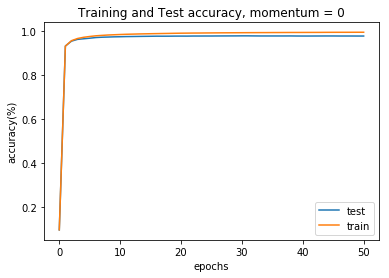

***# Momentum =  0.5 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  972    0    0    0    1    1    4    1    1    0]
 [   1    0 1120    2    5    0    1    2    1    4    0]
 [   2    6    3 1002    3    0    0    2    9    5    2]
 [   3    1    0    6  985    0    6    0    4    6    2]
 [   4    3    0    1    1  947    0    5    1    2   22]
 [   5    4    0    2   12    1  855    4    2    7    5]
 [   6    6    3    1    1    0    4  937    0    6    0]
 [   7    1    4   10    2    4    1    0  987    7   11]
 [   8    6    3    1    3    4    6    4    3  941    3]
 [   9    6    5    0    7    7    1    0    4    5  974]]
final test acc =  0.9720972097209721
final train acc =  0.9952665877764629


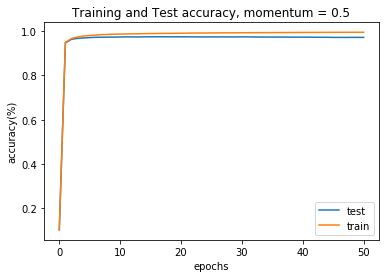

***# Momentum =  1 ***************


/home/jesse/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  979    1    0    0    0    0    0    0    0    0]
 [   1   51 1084    0    0    0    0    0    0    0    0]
 [   2  819  213    0    0    0    0    0    0    0    0]
 [   3  968   42    0    0    0    0    0    0    0    0]
 [   4  956   26    0    0    0    0    0    0    0    0]
 [   5  852   40    0    0    0    0    0    0    0    0]
 [   6  929   29    0    0    0    0    0    0    0    0]
 [   7  963   64    0    0    0    0    0    0    0    0]
 [   8  928   46    0    0    0    0    0    0    0    0]
 [   9  997   12    0    0    0    0    0    0    0    0]]
final test acc =  0.20632063206320633
final train acc =  0.2052367539458991


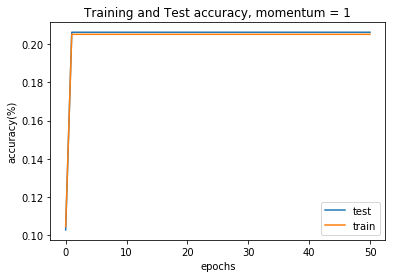

In [90]:
################# EXPERIMENT 2 ####################

epochs = 50
learning_rate = 0.1
momentums = [0, 0.5, 1] #VARY MOMENTUM
hu = 100


for momentum in momentums:
    print("***# Momentum = ",momentum,"***************")
    w_hi = (np.random.rand(785,hu) * 0.10) - 0.05 #weights, input to hidden
    w_oh = (np.random.rand(hu+1,10) * 0.10) - 0.05 #weights, hidden to output
    acc_test = []
    acc_train = []

    acc_test.append(acc(w_hi, w_oh,test_data)) #initial accuracy values
    acc_train.append(acc(w_hi, w_oh,train_data))
    
    for i in range(0,epochs):
        train(w_hi, w_oh, train_data, learning_rate, momentum)
        acc_test.append(acc(w_hi, w_oh,test_data))
        acc_train.append(acc(w_hi, w_oh,train_data))
        print(i, end='', flush=True)
    print(" ") #newline
    
    print(cm(w_hi, w_oh, test_data))
    print("final test acc = ", acc_test[len(acc_test)-1])
    print("final train acc = ", acc_train[len(acc_train)-1])

    plt.plot(acc_test)
    plt.plot(acc_train)
    plt.xlabel("epochs")
    plt.ylabel("accuracy(%)")
    title = "Training and Test accuracy, momentum = " + str(momentum)
    plt.title(title)
    plt.legend(("test", "train"),loc='lower right')
    plt.show()

# Momentum Discussion
*We drop the results with 1.0 momentum from consideration as it caused an overflow, due to the fact that with each weight change, we keep the entirety of the previous weight change. This would cause the delta_weights to grow indefinitely, so the weights themselves would grow faster and faster with each input.
We do, however, include the 0.9 momentum results from Experiment 1, as it uses the same control hyperparameters (100 nodes, 0.1 learning rate, etc).

Momentum theoretically should smooth out the curve, as the weights are less inclined to suddenly shift directions when it keeps a portion of the previous changes. However, with 100 hidden nodes, this effect (if true), is not noticeable as they are both smooth to begin with. From the final accuracy values, we do see an unexpected result in that an increase in momentum causes the final test accuracy to drop (97.8, 97.2, 96.5% from 0, 0.5, and 0.9 momentum respectively). Because the training data seems to be steady at 99.5% for all three networks, this means that the overfitting also increased with momentum (difference between training and test acc. increases). Although slight, it does seem an increase in momentum gives a faster convergence, as expected from the carry-over of weight changes.

***Fraction of total data =  0.25 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  958    0    3    0    0    3    2    2    9    3]
 [   1    0 1115    3    4    0    1    3    2    7    0]
 [   2    2    0  987    2    1    1    2   12   22    3]
 [   3    1    0   12  956    0    5    0    7   22    7]
 [   4    1    1    3    0  922    0    9    1    4   41]
 [   5    4    1    3   25    0  822    5    2   26    4]
 [   6    4    3    6    0    4    7  917    0   13    4]
 [   7    2    4    9    5    3    1    0  981    4   18]
 [   8    3    2    3    2    3    7    3    1  938   12]
 [   9    5    5    2    8   13    2    1   12   15  946]]
final test acc =  0.9542954295429543
final train acc =  0.9992666177745183


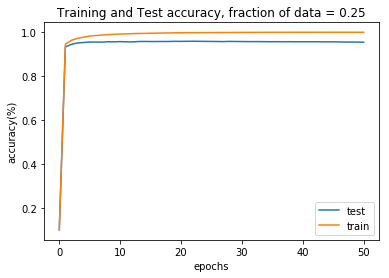

***Fraction of total data =  0.5 ***************
012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849 
[[   0    0    1    2    3    4    5    6    7    8    9]
 [   0  968    2    0    0    1    2    2    0    3    2]
 [   1    1 1117    2    3    0    2    3    1    6    0]
 [   2    5    0  976   10    5    1    4    9   14    8]
 [   3    4    0    9  957    0   14    1    5   12    8]
 [   4    1    1    2    0  946    0    4    1    2   25]
 [   5    6    0    0   17    1  835    7    2   12   12]
 [   6   15    3    2    1    7    5  916    0    9    0]
 [   7    1    4   11    6    7    0    0  973   11   14]
 [   8    9    1    3    4    8    3    3    5  933    5]
 [   9    1    1    0    3   19    2    1    7   10  965]]
final test acc =  0.9586958695869587
final train acc =  0.9969665655521851


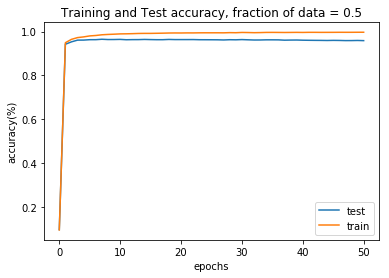

In [91]:
################# EXPERIMENT 3 ####################

epochs = 50
learning_rate = 0.1
momentum = 0.9
hu = 100
data_frac = [0.25, 0.5] #Using a quarter, then a half of the training data
length = len(train_data)

for frac in data_frac:
    ind = int(length*frac) #number of examples in subset of training data
    part_data = train_data[0:ind,:]
    print("***Fraction of total data = ",frac,"***************")
    w_hi = (np.random.rand(785,hu) * 0.10) - 0.05 #weights, input to hidden
    w_oh = (np.random.rand(hu+1,10) * 0.10) - 0.05 #weights, hidden to output
    acc_test = []
    acc_train = []

    acc_test.append(acc(w_hi, w_oh,test_data)) #initial accuracy values
    acc_train.append(acc(w_hi, w_oh,part_data))
    
    for i in range(0,epochs):
        train(w_hi, w_oh, part_data, learning_rate, momentum)
        acc_test.append(acc(w_hi, w_oh,test_data))
        acc_train.append(acc(w_hi, w_oh,part_data))
        print(i, end='', flush=True)
    print(" ") #newline
    
    print(cm(w_hi, w_oh, test_data))
    print("final test acc = ", acc_test[len(acc_test)-1])
    print("final train acc = ", acc_train[len(acc_train)-1])

    plt.plot(acc_test)
    plt.plot(acc_train)
    plt.xlabel("epochs")
    plt.ylabel("accuracy(%)")
    title = "Training and Test accuracy, fraction of data = " + str(frac)
    plt.title(title)
    plt.legend(("test", "train"),loc='lower right')
    plt.show()

# Number of training examples

Increasing the number of training examples provides an increase to the test accuracy (95.4, 95.8, 96.5% for 0.25, 0.5, and 1.0 portion of total data), while the training accuracy decreased marginally, resulting in an overall decrease in overfitting. The speed of convergence appears to be constant, at less than 5 epochs as in experiment 1. 